# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
1,-179,75,4,-203.0,1.702168,9.494461,0.754516,312.468658,29.931450,12.485500,-1.785413
2,-178,75,4,-304.0,1.850258,9.578869,0.735949,291.436279,30.048571,12.902109,-1.904204
3,-177,75,4,-278.0,1.960688,9.668440,0.720070,277.305817,30.211161,13.251008,-1.869162
4,-176,75,4,-247.0,2.056301,9.763065,0.706926,262.947571,30.398439,13.591722,-1.688048


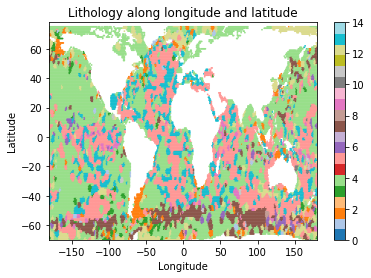

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = plt.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlim([-180, 180])
    plt.ylim([-70, 78])
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.colorbar(sc)
    plt.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

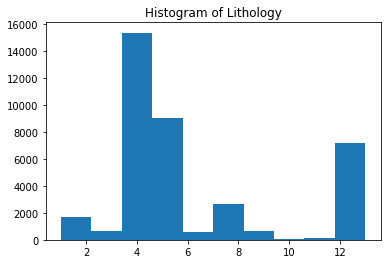

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    plt.hist(y)
    plt.title(title)
    plt.show()

draw_hist(y, "Histogram of Lithology")

In [4]:
training_data = dfdata.copy()

# obtain list of feature names
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.
The neural network has the following structure:

- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Dropout layer : drop out 20% nerons to avoid overfitting
- Output layer

In [5]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
warnings.simplefilter("ignore")

Using TensorFlow backend.


In [19]:
# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)
weight

array([ 8.24463705,  2.1940376 ,  4.53774597,  0.19036398,  0.32419652,
        4.78242836,  1.11968101, 46.45787546,  4.72834597, 34.03309481,
       17.52602487,  1.01661902,  0.68512316])

In [20]:
# calculate weights
unique, counts = np.unique(Y, return_counts=True)
weights = np.zeros(13)
for u, c in zip(unique, counts):
    weights[u] = len(Y) / (13 * c)
weights

array([ 8.24463705,  2.1940376 ,  4.53774597,  0.19036398,  0.32419652,
        4.78242836,  1.11968101, 46.45787546,  4.72834597, 34.03309481,
       17.52602487,  1.01661902,  0.68512316])

In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# define baseline model
def baseline_model():
    activation = "relu"
    dropout_ratio = 0.1
    initializer = "random_uniform"
    numclass = dummy_Y.shape[1]
    model = Sequential()
    model.add(Dense(64, input_dim=X.shape[1], activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(64, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    model.add(Dense(32, activation=activation, kernel_initializer=initializer))
#     model.add(Dropout(rate=dropout_ratio))
    
    # compile
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

# training -> cross validation
nepochs = 50
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=True,
                           class_weight=weight)
kfold = KFold(n_splits=3, shuffle=True, random_state=seed)
results = cross_val_predict(estimator, X, dummy_Y, cv=kfold)

Epoch 1/200
25366/25366 [==============================] - 5s 197us/step - loss: 1.5044 - acc: 0.4785
Epoch 2/200
25366/25366 [==============================] - 5s 195us/step - loss: 1.4023 - acc: 0.5190
Epoch 3/200
25366/25366 [==============================] - 5s 192us/step - loss: 1.3666 - acc: 0.5327
Epoch 4/200
25366/25366 [==============================] - 5s 192us/step - loss: 1.3454 - acc: 0.5393
Epoch 5/200
25366/25366 [==============================] - 5s 189us/step - loss: 1.3330 - acc: 0.5423
Epoch 6/200
25366/25366 [==============================] - 5s 189us/step - loss: 1.3171 - acc: 0.5439
Epoch 7/200
25366/25366 [==============================] - 5s 178us/step - loss: 1.3020 - acc: 0.5490
Epoch 8/200
25366/25366 [==============================] - 5s 180us/step - loss: 1.2882 - acc: 0.5516
Epoch 9/200
25366/25366 [==============================] - 5s 199us/step - loss: 1.2765 - acc: 0.5556
Epoch 10/200
25366/25366 [==============================] - 5s 189us/step - loss: 

25366/25366 [==============================] - 5s 190us/step - loss: 0.9761 - acc: 0.6375
Epoch 81/200
25366/25366 [==============================] - 5s 191us/step - loss: 0.9734 - acc: 0.6451
Epoch 82/200
25366/25366 [==============================] - 5s 193us/step - loss: 0.9707 - acc: 0.6417
Epoch 83/200
25366/25366 [==============================] - 5s 189us/step - loss: 0.9690 - acc: 0.6419
Epoch 84/200
25366/25366 [==============================] - 5s 189us/step - loss: 0.9700 - acc: 0.6403
Epoch 85/200
25366/25366 [==============================] - 5s 189us/step - loss: 0.9673 - acc: 0.6433
Epoch 86/200
25366/25366 [==============================] - 5s 189us/step - loss: 0.9683 - acc: 0.6410
Epoch 87/200
25366/25366 [==============================] - 5s 190us/step - loss: 0.9646 - acc: 0.6435
Epoch 88/200
25366/25366 [==============================] - 5s 188us/step - loss: 0.9619 - acc: 0.6456
Epoch 89/200
25366/25366 [==============================] - 5s 187us/step - loss: 0.96

25366/25366 [==============================] - 5s 189us/step - loss: 0.8959 - acc: 0.6683
Epoch 160/200
25366/25366 [==============================] - 5s 188us/step - loss: 0.8958 - acc: 0.6657
Epoch 161/200
25366/25366 [==============================] - 5s 187us/step - loss: 0.8972 - acc: 0.6683
Epoch 162/200
25366/25366 [==============================] - 5s 185us/step - loss: 0.9019 - acc: 0.6646
Epoch 163/200
25366/25366 [==============================] - 5s 185us/step - loss: 0.8926 - acc: 0.6693
Epoch 164/200
25366/25366 [==============================] - 5s 185us/step - loss: 0.8986 - acc: 0.6653
Epoch 165/200
25366/25366 [==============================] - 5s 187us/step - loss: 0.8908 - acc: 0.6688
Epoch 166/200
25366/25366 [==============================] - 5s 188us/step - loss: 0.8945 - acc: 0.6653
Epoch 167/200
25366/25366 [==============================] - 5s 188us/step - loss: 0.8913 - acc: 0.6683
Epoch 168/200
25366/25366 [==============================] - 5s 188us/step - l

25366/25366 [==============================] - 5s 191us/step - loss: 1.0811 - acc: 0.6080
Epoch 38/200
25366/25366 [==============================] - 5s 193us/step - loss: 1.0777 - acc: 0.6089
Epoch 39/200
25366/25366 [==============================] - 5s 191us/step - loss: 1.0722 - acc: 0.6147
Epoch 40/200
25366/25366 [==============================] - 5s 200us/step - loss: 1.0682 - acc: 0.6117
Epoch 41/200
25366/25366 [==============================] - 5s 202us/step - loss: 1.0656 - acc: 0.6134
Epoch 42/200
25366/25366 [==============================] - 5s 202us/step - loss: 1.0633 - acc: 0.6138
Epoch 43/200
25366/25366 [==============================] - 5s 198us/step - loss: 1.0583 - acc: 0.6161
Epoch 44/200
25366/25366 [==============================] - 5s 199us/step - loss: 1.0545 - acc: 0.6167
Epoch 45/200
25366/25366 [==============================] - 5s 200us/step - loss: 1.0496 - acc: 0.6180
Epoch 46/200
25366/25366 [==============================] - 5s 204us/step - loss: 1.04

25366/25366 [==============================] - 5s 192us/step - loss: 0.9285 - acc: 0.6556
Epoch 117/200
25366/25366 [==============================] - 5s 195us/step - loss: 0.9252 - acc: 0.6574
Epoch 118/200
25366/25366 [==============================] - 5s 189us/step - loss: 0.9250 - acc: 0.6610
Epoch 119/200
25366/25366 [==============================] - 5s 193us/step - loss: 0.9266 - acc: 0.6567
Epoch 120/200
25366/25366 [==============================] - 5s 194us/step - loss: 0.9215 - acc: 0.6618
Epoch 121/200
25366/25366 [==============================] - 5s 196us/step - loss: 0.9218 - acc: 0.6590
Epoch 122/200
25366/25366 [==============================] - 5s 196us/step - loss: 0.9218 - acc: 0.6596
Epoch 123/200
25366/25366 [==============================] - 5s 197us/step - loss: 0.9198 - acc: 0.6601
Epoch 124/200
25366/25366 [==============================] - 5s 190us/step - loss: 0.9251 - acc: 0.6609
Epoch 125/200
25366/25366 [==============================] - 5s 192us/step - l

25366/25366 [==============================] - 5s 193us/step - loss: 0.8709 - acc: 0.6743
Epoch 195/200
25366/25366 [==============================] - 5s 196us/step - loss: 0.8683 - acc: 0.6774
Epoch 196/200
25366/25366 [==============================] - 5s 196us/step - loss: 0.8678 - acc: 0.6791
Epoch 197/200
25366/25366 [==============================] - 5s 191us/step - loss: 0.8711 - acc: 0.6787
Epoch 198/200
25366/25366 [==============================] - 5s 192us/step - loss: 0.8662 - acc: 0.6770
Epoch 199/200
25366/25366 [==============================] - 5s 192us/step - loss: 0.8652 - acc: 0.6787
Epoch 200/200
12683/12683 [==============================] - 1s 93us/step
Epoch 1/200
25366/25366 [==============================] - 5s 206us/step - loss: 1.5070 - acc: 0.4824
Epoch 2/200
25366/25366 [==============================] - 5s 205us/step - loss: 1.3866 - acc: 0.5221
Epoch 3/200
25366/25366 [==============================] - 5s 200us/step - loss: 1.3551 - acc: 0.5360
Epoch 4/20

25366/25366 [==============================] - 5s 203us/step - loss: 0.9652 - acc: 0.6440
Epoch 74/200
25366/25366 [==============================] - 5s 200us/step - loss: 0.9633 - acc: 0.6454
Epoch 75/200
25366/25366 [==============================] - 5s 203us/step - loss: 0.9617 - acc: 0.6455
Epoch 76/200
25366/25366 [==============================] - 5s 204us/step - loss: 0.9571 - acc: 0.6449
Epoch 77/200
25366/25366 [==============================] - 5s 202us/step - loss: 0.9568 - acc: 0.6484
Epoch 78/200
25366/25366 [==============================] - 5s 204us/step - loss: 0.9552 - acc: 0.6481
Epoch 79/200
25366/25366 [==============================] - 5s 201us/step - loss: 0.9522 - acc: 0.6475
Epoch 80/200
25366/25366 [==============================] - 5s 201us/step - loss: 0.9504 - acc: 0.6476
Epoch 81/200
25366/25366 [==============================] - 5s 203us/step - loss: 0.9521 - acc: 0.6476
Epoch 82/200
25366/25366 [==============================] - 5s 205us/step - loss: 0.94

25366/25366 [==============================] - 5s 204us/step - loss: 0.8734 - acc: 0.6735
Epoch 153/200
25366/25366 [==============================] - 5s 200us/step - loss: 0.8791 - acc: 0.6742
Epoch 154/200
25366/25366 [==============================] - 5s 203us/step - loss: 0.8759 - acc: 0.6764
Epoch 155/200
25366/25366 [==============================] - 5s 202us/step - loss: 0.8769 - acc: 0.6739
Epoch 156/200
25366/25366 [==============================] - 5s 204us/step - loss: 0.8714 - acc: 0.6759
Epoch 157/200
25366/25366 [==============================] - 5s 198us/step - loss: 0.8746 - acc: 0.6746
Epoch 158/200
25366/25366 [==============================] - 5s 201us/step - loss: 0.8694 - acc: 0.6762
Epoch 159/200
25366/25366 [==============================] - 5s 205us/step - loss: 0.8721 - acc: 0.6754
Epoch 160/200
25366/25366 [==============================] - 5s 200us/step - loss: 0.8701 - acc: 0.6761
Epoch 161/200
25366/25366 [==============================] - 5s 203us/step - l

Accuracy = 0.6259560040999763


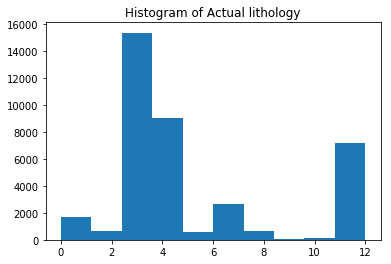

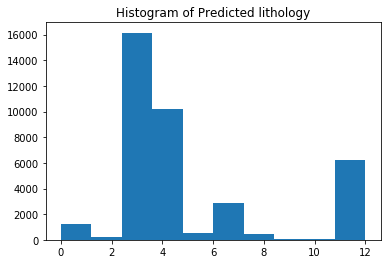

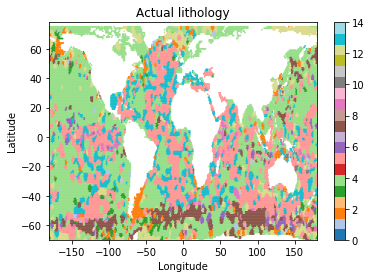

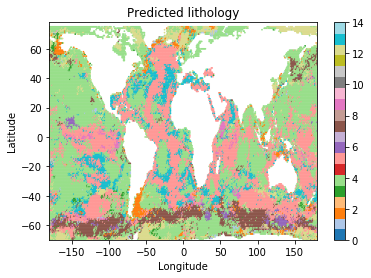

In [7]:
print("Accuracy = {}".format(accuracy_score(Y, results)))
draw_hist(Y + 1, "Histogram of Actual lithology")
draw_hist(results + 1, "Histogram of Predicted lithology")
draw_global(lon, lat, y, "Actual lithology")
draw_global(lon, lat, results + 1, "Predicted lithology")